In [ ]:
! pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import BorderlineSMOTE
from tensorflow.keras.utils import to_categorical

In [ ]:
df = pd.read_csv('/content/Dataset_challenge.csv')

In [ ]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


<Axes: >

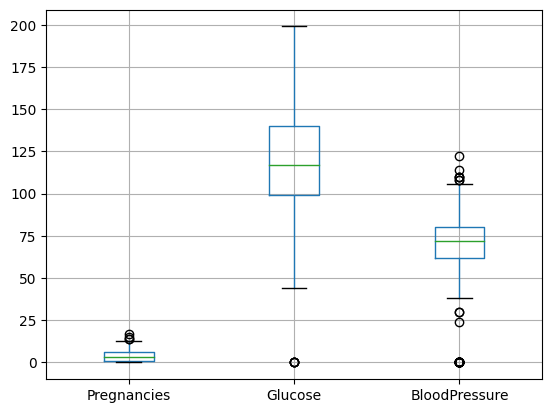

In [ ]:
boxplot = df.boxplot(column=['Pregnancies', 'Glucose', 'BloodPressure'])
boxplot

In [ ]:
header = ['Pregnancies',	'Glucose',	'BloodPressure', 'SkinThickness',	'Insulin',	'BMI',	'DiabetesPedigreeFunction',	'Age']
outlier = {"Pregnancies": [],	"Glucose": [],	"BloodPressure": [],	"SkinThickness": [],	"Insulin": [],	"BMI": [],	"DiabetesPedigreeFunction": [],	"Age": []}
for header in header:
  array = df[header].to_numpy()
  q1 = np.percentile(array, 25)
  q3 = np.percentile(array, 75)
  iqr = q3 - q1

  lower = q1 - 1.5 * iqr
  upper = q3 + 1.5 * iqr

  upper_arr = np.where(df[header] >= upper)
  lower_arr = np.where(df[header] <= lower)

  outlier_index = np.append(upper_arr, lower_arr)

  outlier[header].append(outlier_index)

df_std = df.iloc[:, :8]

In [ ]:
scaler = MinMaxScaler()
df_std.to_numpy()
scaler.fit(df_std)
data = scaler.transform(df_std)
df_std = pd.DataFrame(data, columns=['Pregnancies',	'Glucose',	'BloodPressure',	'SkinThickness',	'Insulin',	'BMI',	'DiabetesPedigreeFunction',	'Age'])

In [ ]:
df_train = df_std[:594]
df_test = df_std[595:]

In [ ]:
original = []
for value in outlier.values():
    for num in value:
      num = num.tolist()
      original += num

dupe = ([x for x in original if original.count(x) > 1])

In [ ]:
for i in dupe:
  if i > 594:
    print(i)
    dupe.remove(i)

706


In [ ]:
df_label_train = df.iloc[:, 8][:594]
df_train = pd.concat([df_train, df_label_train], axis=1)
df_update = df_train.drop(index=dupe)

In [ ]:
x_train = df_update.iloc[:, :8][:594]
y_train = df_update.iloc[:, 8][:594]

x_test = df_std.iloc[:, :8][594:]
y_test = df.iloc[:, 8][594:]

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(8,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Recall'])

history = model.fit(x_train, y_train,
                    validation_data = (x_test, y_test),
                    epochs = 200,
                    batch_size = 20)

In [ ]:
def model_builder(hp):
  model = Sequential()
  hp_units_1 = hp.Int('units1', min_value=16, max_value=512, step=8)
  hp_units_2 = hp.Int('units2', min_value=32, max_value=512, step=8)
  hp_units_3 = hp.Int('units3', min_value=32, max_value=512, step=8)

  model.add(Dense(units = hp_units_1, input_shape=(8,), activation='relu'))
  model.add(Dense(units = hp_units_2, activation='relu'))
  model.add(Dense(units = hp_units_3, activation='relu'))
  model.add(Dense(2, activation='sigmoid'))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy', 'Recall'])

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = 100,
                     factor = 3,
                     directory = 'my_dir_border_smote',
                     project_name = 'intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

In [ ]:
sm = BorderlineSMOTE(random_state=42)
X_res, y_res = sm.fit_resample(x_train, y_train)

y_res = to_categorical(y_res, 2)

In [ ]:
X_res.shape, y_res.shape

((756, 8), (756, 2))

In [ ]:
tuner.search(X_res, y_res,
             validation_data = (x_test, y_test),
             epochs=50,
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units1')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 254 Complete [00h 00m 07s]
val_accuracy: 0.8103448152542114

Best val_accuracy So Far: 0.8563218116760254
Total elapsed time: 00h 14m 47s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 144 and the optimal learning rate for the optimizer
is 0.01.



In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_learning_rate = best_hps.get('learning_rate')

model_smote = model_builder(best_hps)

In [ ]:
best_learning_rate

0.01

In [ ]:
model_smote.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 144)               1296      
                                                                 
 dense_5 (Dense)             (None, 472)               68440     
                                                                 
 dense_6 (Dense)             (None, 336)               158928    
                                                                 
 dense_7 (Dense)             (None, 2)                 674       
                                                                 
Total params: 229338 (895.85 KB)
Trainable params: 229338 (895.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model_smote.fit(X_res, y_res,
                          validation_data = (x_test, y_test),
                          epochs = 200,
                          batch_size = 20)

Epoch 1/200
38/38 [==============================] - 2s 11ms/step - loss: 0.6558 - accuracy: 0.5992 - recall: 0.6005 - val_loss: 0.5357 - val_accuracy: 0.6667 - val_recall: 0.6667
Epoch 2/200
38/38 [==============================] - 0s 6ms/step - loss: 0.6368 - accuracy: 0.6071 - recall: 0.6045 - val_loss: 0.5559 - val_accuracy: 0.6839 - val_recall: 0.6839
Epoch 3/200
38/38 [==============================] - 0s 6ms/step - loss: 0.5726 - accuracy: 0.7037 - recall: 0.7024 - val_loss: 0.4316 - val_accuracy: 0.8103 - val_recall: 0.8103
Epoch 4/200
38/38 [==============================] - 0s 5ms/step - loss: 0.5555 - accuracy: 0.7090 - recall: 0.7090 - val_loss: 0.4158 - val_accuracy: 0.7931 - val_recall: 0.7989
Epoch 5/200
38/38 [==============================] - 0s 6ms/step - loss: 0.5437 - accuracy: 0.7368 - recall: 0.7368 - val_loss: 0.4549 - val_accuracy: 0.7816 - val_recall: 0.7816
Epoch 6/200
38/38 [==============================] - 0s 6ms/step - loss: 0.5383 - accuracy: 0.7063 - rec

In [ ]:
from keras.callbacks import ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Dense(352, input_shape=(8,), activation='relu'))
model.add(Dense(344, activation='relu'))
model.add(Dense(480, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy', 'Recall'])
mcp_save = ModelCheckpoint('best.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

history = model.fit(x_train, y_train,
                    validation_data = (x_test, y_test),
                    epochs = 200,
                    batch_size = 16,
                    callbacks=[mcp_save])

Epoch 1/200
37/37 [==============================] - 3s 26ms/step - loss: 0.6668 - accuracy: 0.6442 - recall: 0.6477 - val_loss: 0.6297 - val_accuracy: 0.6437 - val_recall: 0.6437
Epoch 2/200
11/37 [=======>......................] - ETA: 0s - loss: 0.6442 - accuracy: 0.6250 - recall: 0.6250

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 1s 14ms/step - loss: 0.6001 - accuracy: 0.6649 - recall: 0.6598 - val_loss: 0.6447 - val_accuracy: 0.6264 - val_recall: 0.6264
Epoch 3/200
37/37 [==============================] - 1s 14ms/step - loss: 0.5628 - accuracy: 0.7098 - recall: 0.7064 - val_loss: 0.4908 - val_accuracy: 0.7874 - val_recall: 0.7874
Epoch 4/200
37/37 [==============================] - 0s 9ms/step - loss: 0.5422 - accuracy: 0.7271 - recall: 0.7271 - val_loss: 0.4843 - val_accuracy: 0.7414 - val_recall: 0.7414
Epoch 5/200
37/37 [==============================] - 0s 10ms/step - loss: 0.5283 - accuracy: 0.7358 - recall: 0.7358 - val_loss: 0.4923 - val_accuracy: 0.7931 - val_recall: 0.7989
Epoch 6/200
37/37 [==============================] - 0s 9ms/step - loss: 0.4972 - accuracy: 0.7461 - recall: 0.7461 - val_loss: 0.4332 - val_accuracy: 0.7989 - val_recall: 0.8046
Epoch 7/200
37/37 [==============================] - 0s 7ms/step - loss: 0.4855 - accuracy: 0.7547 - recall: 0.754

In [ ]:
final_model = keras.models.load_model('/content/best.hdf5')

In [ ]:
y_pred = final_model.predict(x_test)

6/6 [==============================] - 0s 4ms/step


In [ ]:
threshold = 0.5

binary_data = (y_pred >= threshold).astype(int)

In [ ]:
output_pred = [np.where(r==1)[0][0] for r in binary_data]
output_test = [np.where(r==1)[0][0] for r in y_test]

In [ ]:
from sklearn.metrics import recall_score

recall_score(output_test, output_pred, average='micro')

0.8505747126436781

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(output_test, output_pred)

0.8505747126436781

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(output_test, output_pred)

array([[100,  12],
       [ 14,  48]])

In [ ]:
tuner_rs = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='keras_tuner_example'
)

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

In [ ]:
tuner_rs.search(X_res, y_res,
             validation_data = (x_test, y_test),
             epochs=50,
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps_rs = tuner_rs.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps_rs.get('units1')} and the optimal learning rate for the optimizer
is {best_hps_rs.get('learning_rate')}.
""")

Trial 5 Complete [00h 00m 20s]
val_accuracy: 0.8352490266164144

Best val_accuracy So Far: 0.8352490266164144
Total elapsed time: 00h 01m 31s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 152 and the optimal learning rate for the optimizer
is 0.001.

